In [1]:
# import packages
import time
import json
from PIL import Image, ImageDraw
import numpy as np
import pydicom
from highdicom.content import (
    AlgorithmIdentificationSequence,
    CodedConcept
)
import highdicom as hd
from shapely import wkt
import matplotlib.pyplot as plt

In [2]:
# define variables
wkt_input = "example/input/wkt.json"
dicom_input = "example/input/dicom_image.dcm"

In [3]:
def create_mask_from_geometry(geometry_data, img_width, img_height):
    """Create a binary mask from geometry data."""
    # Create blank canvas
    canvas = np.zeros((img_height, img_width))
    mask_image = Image.fromarray(np.uint8(canvas))

    # Get the mask polygon
    mask_polygon = wkt.loads(geometry_data['geometries'])

    # Coordinates should be provided in absolute terms. Any scaling should be done earlier in the process.
    mask_poly_coords = list(mask_polygon.exterior.coords)

    if mask_polygon.is_empty:
        return np.zeros((img_height, img_width), dtype=np.uint8)

    ImageDraw.Draw(mask_image).polygon(mask_poly_coords, fill=1)

    # Convert to numpy array and check contents
    mask_array = np.array(mask_image, dtype=np.uint8)

    return mask_array

In [4]:
def create_dicom_seg(geometry_data, dicom_file, output_path):
    """Create a DICOM SEG file."""
    
    dicom_dataset = pydicom.dcmread(dicom_file)
    img_width, img_height = dicom_dataset.Columns, dicom_dataset.Rows

    # Generate masks
    all_masks = []
    segment_descriptions = []

    for idx, geometry in enumerate(geometry_data):
        mask = create_mask_from_geometry(geometry, img_width, img_height)

        if np.any(mask):
            all_masks.append(mask)
                
    # Define the identifiers and description for the conversion. These hardcoded values are only a sample for tutorial purposes and aren't meant to be used as is
            algorithm_identification = AlgorithmIdentificationSequence(
                name='WKT Conversion',
                version='1.0',
                family=CodedConcept(
                    value="125001",
                    scheme_designator="DCM",
                    meaning="Artificial Intelligence"
                )
            )

            description = hd.seg.SegmentDescription(
                segment_number=len(segment_descriptions) + 1,
                segment_label=geometry['answer_class'],
                segmented_property_category=CodedConcept(
                    value="85756007",
                    scheme_designator="SCT",
                    meaning="Tissue"
                ),
                segmented_property_type=CodedConcept(
                    value="85756007",
                    scheme_designator="SCT",
                    meaning="Tissue"
                ),
                algorithm_type=hd.seg.SegmentAlgorithmTypeValues.MANUAL,
                algorithm_identification=algorithm_identification
            )
            segment_descriptions.append(description)
        else:
            print(f"No valid mask created for geometry {idx}")

    if not all_masks:
        raise ValueError("No valid masks were created from the geometry data")

    masks_array = np.stack(all_masks, axis=0)
    answer_classes = [item["answer_class"] for item in geometry_data]

    visualize_dicom_and_masks(dicom_file, masks_array, answer_classes)

    seg_dataset = hd.seg.Segmentation(
        source_images=[dicom_dataset],
        pixel_array=masks_array,
        segmentation_type=hd.seg.SegmentationTypeValues.BINARY,
        segment_descriptions=segment_descriptions,
        series_instance_uid=hd.UID(),
        series_number=1,
        sop_instance_uid=hd.UID(),
        instance_number=1,
        manufacturer='Manufacturer',
        manufacturer_model_name='Model',
        software_versions='v1.0',
        device_serial_number='0000'
    )

    # Save the DICOM SEG file
    seg_dataset.save_as(output_path)
    return {"message": "DICOM SEG file created successfully", "file_path": output_path}

In [5]:
def visualize_dicom_and_masks(dicom_path, masks_array, answer_classes):
    """
    Visualize DICOM image with mask overlays, ensuring consistent colors by answer_class.
    
    Args:
        dicom_path: Path to the DICOM file
        masks_array: 3D numpy array of masks (num_masks, height, width)
        answer_classes: List of answer_class labels corresponding to each mask
    """
    import matplotlib.colors as mcolors

    # Read DICOM file
    dicom_dataset = pydicom.dcmread(dicom_path)
    dicom_image = dicom_dataset.pixel_array

    # Ensure masks are binary (0 or 1)
    masks_array = (masks_array > 0).astype(np.uint8)

    # Assign colors to answer classes
    unique_classes = list(set(answer_classes))  # Get unique answer classes
    color_palette = plt.cm.tab10.colors  # Use a predefined color palette
    color_map = {cls: color_palette[i % len(color_palette)] for i, cls in enumerate(unique_classes)}

    # Calculate number of subplots needed
    num_masks = masks_array.shape[0]
    total_plots = num_masks + 1  # +1 for original image

    # Create figure with subplots
    fig, axes = plt.subplots(1, total_plots, figsize=(5 * total_plots, 5))
    if total_plots == 2:  # Handle case of single mask
        axes = [axes[0], axes[1]]

    # Plot original DICOM image
    axes[0].imshow(dicom_image, cmap='gray')
    axes[0].set_title('Original DICOM')
    axes[0].axis('off')

    # Plot each mask as overlay
    for i in range(num_masks):
        answer_class = answer_classes[i]
        color = color_map[answer_class]  # Get color for the answer_class
        mask = masks_array[i]

        # Create a color overlay
        colored_mask = np.zeros((*mask.shape, 4))  # RGBA format
        colored_mask[mask == 1] = (*color, 0.5)  # Apply color with 50% transparency

        axes[i + 1].imshow(dicom_image, cmap='gray')
        axes[i + 1].imshow(colored_mask, interpolation='none')
        axes[i + 1].set_title(f'Mask {i + 1}: {answer_class}')
        axes[i + 1].axis('off')

    plt.tight_layout()
    plt.show()

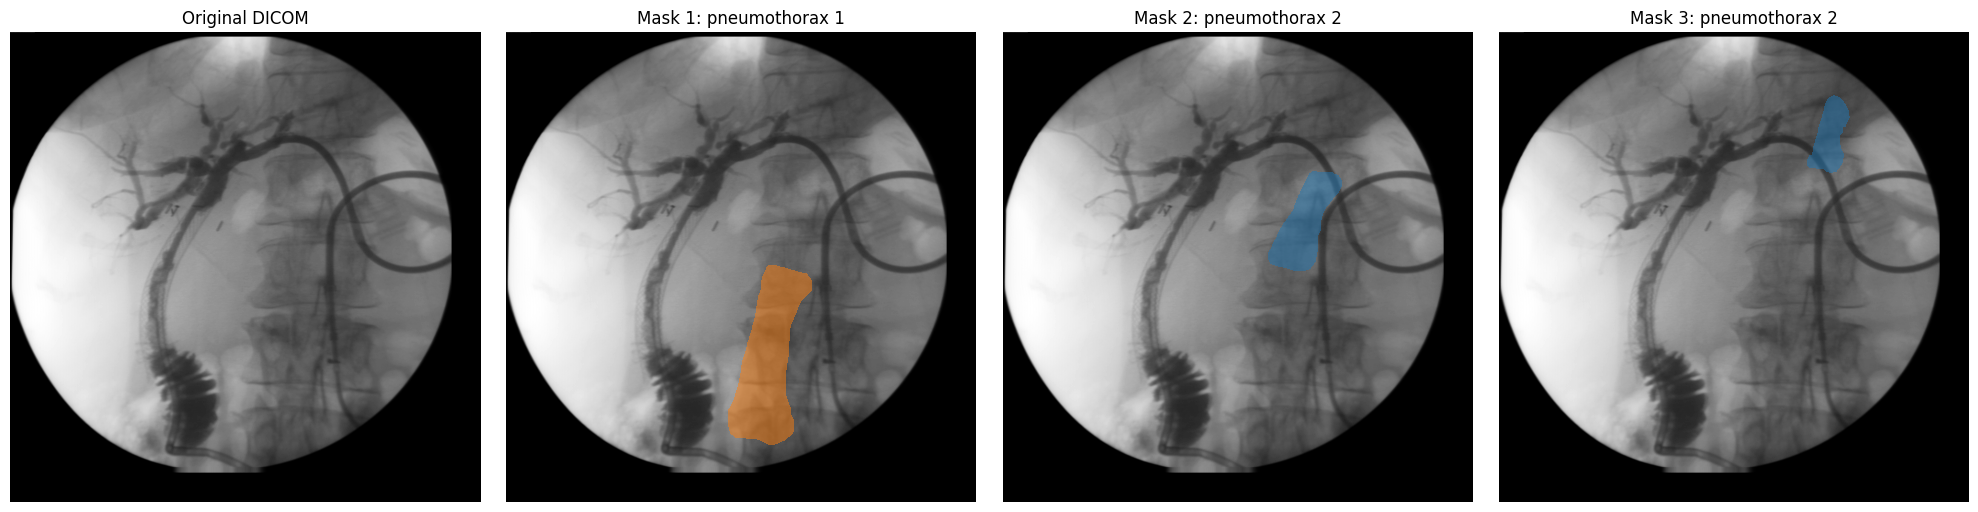

Success! DICOM SEG file created at: example/output/segmentation_1737721823.dcm


/Users/nkwudalyndanwankwo/Documents/Centaur/ingestpy/python12/lib/python3.12/site-packages/highdicom/base.py:163: UserWarning: The string "Rubo DEMO" is unlikely to represent the intended person name since it contains only a single component. Construct a person name according to the format in described in https://dicom.nema.org/dicom/2013/output/chtml/part05/sect_6.2.html#sect_6.2.1.2, or, in pydicom 2.2.0 or later, use the pydicom.valuerep.PersonName.from_named_components() method to construct the person name correctly. If a single-component name is really intended, add a trailing caret character to disambiguate the name.
  check_person_name(patient_name)


In [6]:
try:
    # Load geometry data
    with open(wkt_input, 'r') as geometry_file:
        geometry_data = json.load(geometry_file)

    # Generate output DICOM SEG file path
    output_path = f"example/output/segmentation_{int(time.time())}.dcm"

    # Create DICOM SEG file
    result = create_dicom_seg(geometry_data, dicom_input, output_path)

    if "error" in result:
        print(f"Error: {result['error']}")
    else:
        print(f"Success! DICOM SEG file created at: {result['file_path']}")

except Exception as e:
    print(f"Error: {str(e)}")